# **1. Import thư viện**

In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
import warnings
warnings.filterwarnings('ignore')

# **2. Chuẩn bị dữ liệu**

In [22]:
# Tải dữ liệu
df = pd.read_csv('ECommerce_Dataset_cleaned_model.csv')

In [23]:
df.shape

(5630, 15)

In [24]:
df.head()

,Churn,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,DaySinceLastOrder,CashbackAmount,DevicePerTenure
0,1,3,6,3,3,Laptop & Accessory,2,Single,9,1,11,1,5,160,0.75
1,1,1,8,3,4,Mobile Phone,3,Single,7,1,15,0,0,121,4.00
2,1,1,30,2,4,Mobile Phone,3,Single,6,1,14,0,3,120,4.00
3,1,3,15,2,4,Laptop & Accessory,5,Single,8,0,23,0,3,134,4.00
4,1,1,12,3,3,Mobile Phone,5,Single,3,0,11,1,3,130,3.00


In [25]:
# Xác định biến đầu vào và mục tiêu
target = 'Churn'

X = df.drop(columns=[target])
y = df[target]

In [26]:
# Xác định cột định lượng (numeric) và định tính (categorical)
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# **3. Tạo Pipeline (Tiền xử lý + Mô hình)**

In [27]:
# ColumnTransformer: One-Hot Encoding + Scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

In [28]:
# Xây dựng model
model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=20,
    max_depth=5,
    min_child_samples=30,
    class_weight='balanced',
    random_state=42
)

In [29]:
# Xây dựng Pipeline
clf = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

In [30]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# **4. Cross validation (10-fold)**

In [31]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_pred_cv = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict')
y_proba_cv = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

[LightGBM] [Info] Number of positive: 682, number of negative: 3371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 445
[LightGBM] [Info] Number of data points in the train set: 4053, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [32]:
roc_auc_cv = roc_auc_score(y_train, y_proba_cv)
print(f"CV ROC-AUC: {roc_auc_cv:.5f}")

CV ROC-AUC: 0.96369


In [33]:
print("\nClassification Report (Cross-Validation on Train):")
print(classification_report(y_train, y_pred_cv))


Classification Report (Cross-Validation on Train):
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3746
           1       0.74      0.88      0.80       758

    accuracy                           0.93      4504
   macro avg       0.86      0.91      0.88      4504
weighted avg       0.93      0.93      0.93      4504



# **5. Huấn luyện & dự đoán**

In [34]:
# Train model
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 758, number of negative: 3746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 4504, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CityTier',
                                                   'WarehouseToHome',
                                                   'HourSpendOnApp',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'OrderAmountHikeFromlastYear',
                                                   'CouponUsed',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount',
                                                   'DevicePerTenure']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('model',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.05,
                                max_depth=5, min_child_samples=30,
                                n_estimators=300, num_leaves=20,
                                random_state=42))])

In [35]:
# Dự đoán
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

# **6. Đánh giá mô hình**


In [36]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       936
           1       0.79      0.95      0.86       190

    accuracy                           0.95      1126
   macro avg       0.89      0.95      0.91      1126
weighted avg       0.95      0.95      0.95      1126



**Nhận xét:**

- Mô hình LightGBM đạt **accuracy 95%** và **F1-score trung bình 0.91**, cho thấy hiệu quả phân loại tổng thể tốt.

  - Lớp 0 (không churn): **precision rất cao (0.99)** và **recall 0.95**, hầu hết dự đoán lớp này chính xác, chỉ một phần nhỏ bị nhầm sang churn. **F1-score 0.97** cho thấy cân bằng tốt giữa precision và recall.

  - Lớp 1 (churn): **recall đạt 0.95, F1-score 0.86**, mô hình phát hiện hầu hết khách hàng churn, nhưng **precision 0.79** phản ánh vẫn còn một số dự đoán nhầm từ lớp 0 sang 1.

- Nhìn chung, mô hình xử lý tốt dữ liệu mất cân bằng, cân bằng giữa việc phát hiện churn và hạn chế false positive, phù hợp cho bài toán churn.


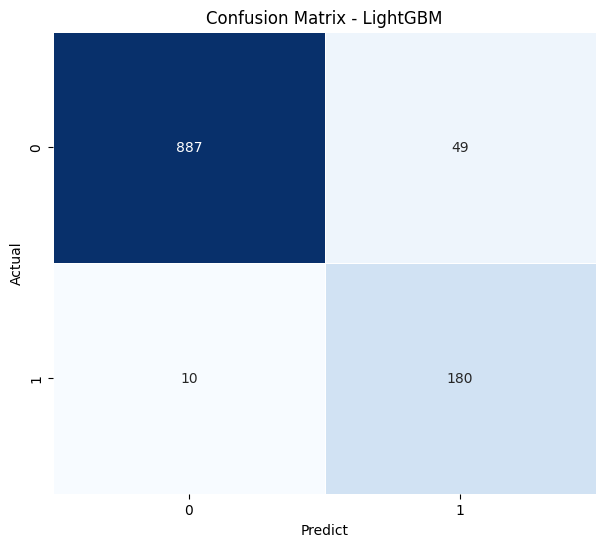

In [37]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=False, linewidths=0.5)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LightGBM')
plt.show()

**Nhận xét:**

- Phát hiện chính xác **180 khách hàng sẽ rời bỏ**, giúp các chiến dịch giữ chân đi đúng mục tiêu.

- Xác định đúng **887 khách hàng trung thành**, tránh lãng phí chi phí và làm phiền họ.

- Mô hình đã không phát hiện được 10 khách hàng thực sự rời bỏ.

- Mô hình đã dự đoán nhầm 49 khách hàng trung thành là sẽ rời bỏ, có thể gây lãng phí chi phí chăm sóc.

-  Với tổng số lỗi là 59 trên 1126 mẫu kiểm tra, độ chính xác tổng thể đạt **94.76%**, đây là một kết quả rất tốt.

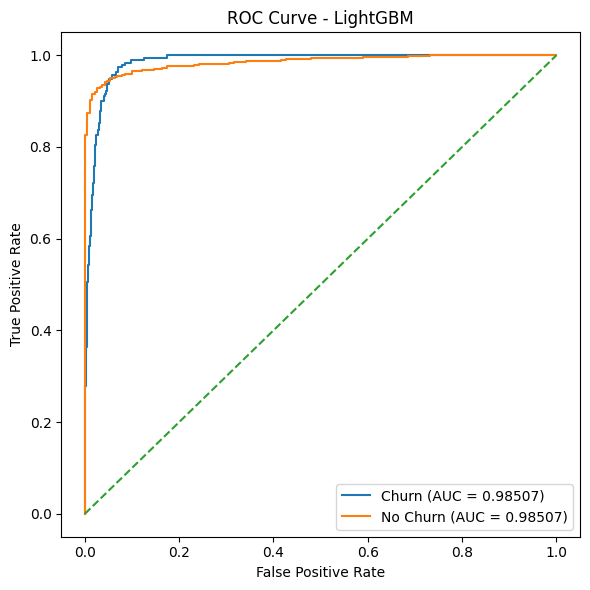

In [38]:
# vẽ ROC Curve

# Lớp churn = 1
fpr_1, tpr_1, _ = roc_curve(y_test, y_proba[:, 1])
auc_1 = auc(fpr_1, tpr_1)

# Lớp churn = 0
fpr_0, tpr_0, _ = roc_curve(1 - y_test, y_proba[:, 0])
auc_0 = auc(fpr_0, tpr_0)

plt.figure(figsize=(6, 6))
plt.plot(fpr_1, tpr_1, label=f'Churn (AUC = {auc_1:.5f})')
plt.plot(fpr_0, tpr_0, label=f'No Churn (AUC = {auc_0:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend()
plt.tight_layout()
plt.show()

**Nhận xét:**

 - Diện tích dưới đường cong (AUC) đạt **0.98507**, cho thấy mô hình có khả năng phân biệt tốt giữa khách hàng sẽ rời bỏ và khách hàng sẽ ở lại.

- Đường cong ôm sát góc trên bên trái cho thấy mô hình có thể phát hiện gần như toàn bộ khách hàng sẽ rời bỏ mà không bị nhầm lẫn nhiều.